In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn import metrics
from category_encoders import TargetEncoder

In [2]:
log_shots = pd.read_csv('shot_logs.csv')

In [3]:
def convert_game_clock_to_seconds(clock_str):
    if isinstance(clock_str, str):
        parts = clock_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
    return np.nan

log_shots['GAME_CLOCK_SECONDS'] = log_shots['GAME_CLOCK'].apply(convert_game_clock_to_seconds)
log_shots[['GAME_CLOCK', 'GAME_CLOCK_SECONDS']].head()
log_shots.drop(columns=['GAME_CLOCK'], inplace=True)
log_shots = log_shots.dropna(how = 'any', axis = 0)

In [4]:
log_shots.loc[log_shots['LOCATION'] == 'H', 'LOCATION'] = 1
log_shots.loc[log_shots['LOCATION'] == 'A', 'LOCATION'] = 0
log_shots['LOCATION'] = log_shots['LOCATION'].astype('int32')

log_shots.loc[log_shots['SHOT_RESULT'] == 'made', 'SHOT_RESULT'] = 1
log_shots.loc[log_shots['SHOT_RESULT'] == 'missed', 'SHOT_RESULT'] = 0
log_shots['SHOT_RESULT'] = log_shots['SHOT_RESULT'].astype('int32')

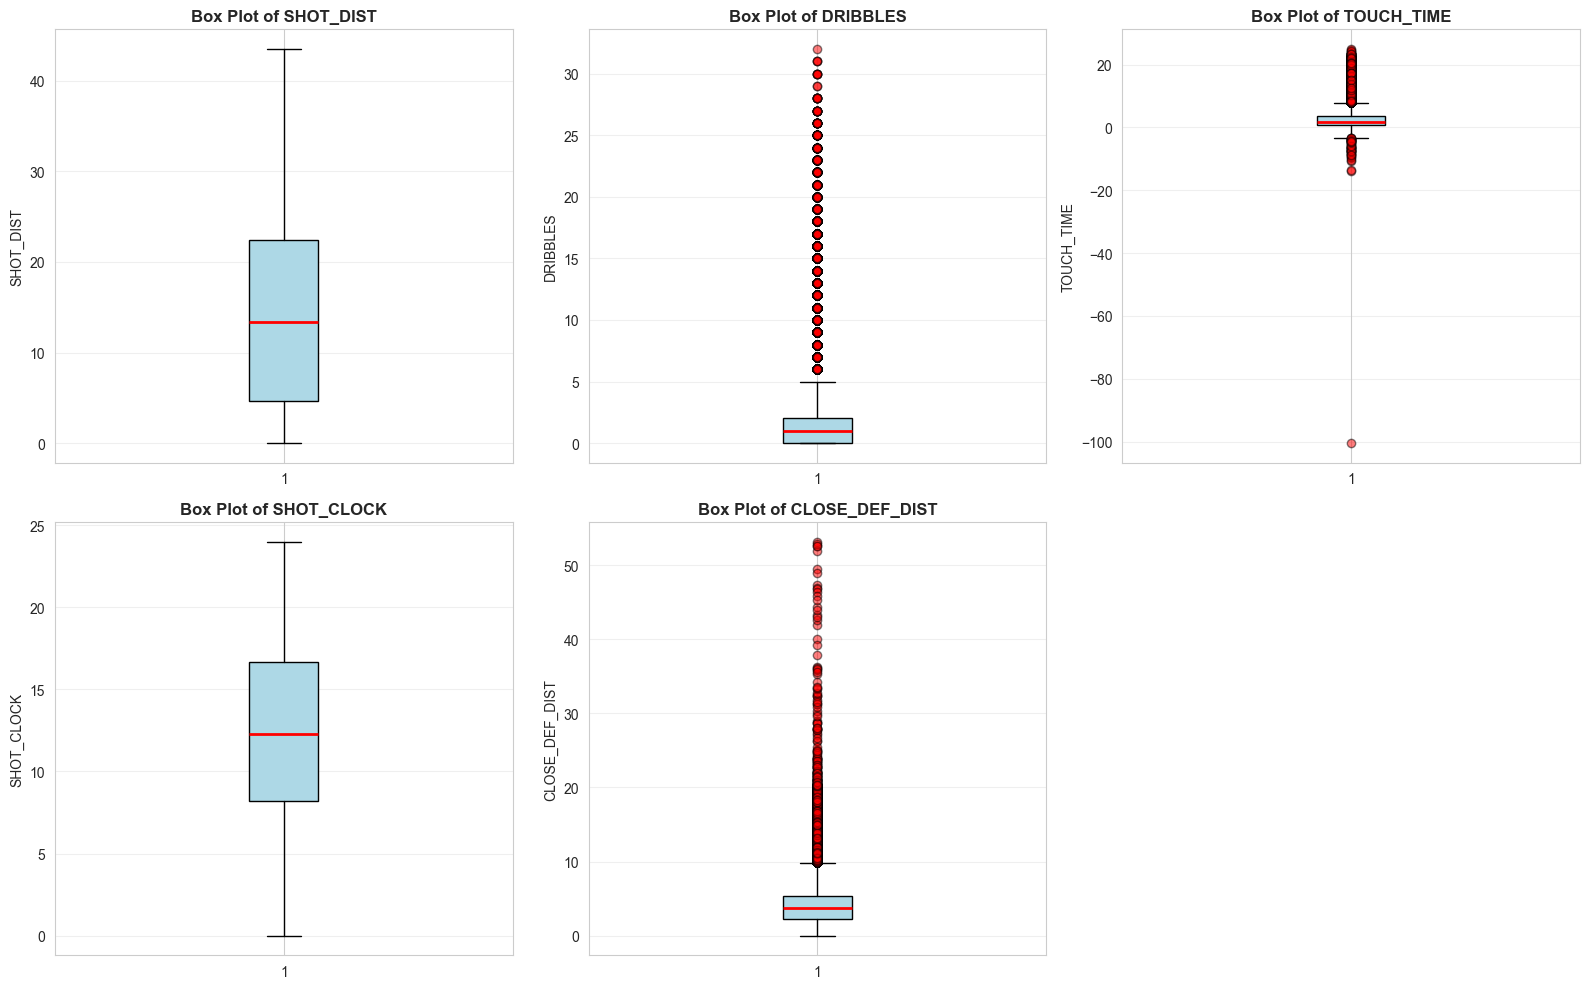

OUTLIER ANALYSIS

SHOT_DIST:
  Q1: 4.70, Q3: 22.40, IQR: 17.70
  Lower Bound: -21.85, Upper Bound: 48.95
  Number of Outliers: 0 (0.00%)
  Outlier Range: [nan, nan]

DRIBBLES:
  Q1: 0.00, Q3: 2.00, IQR: 2.00
  Lower Bound: -3.00, Upper Bound: 5.00
  Number of Outliers: 14032 (11.45%)
  Outlier Range: [6.00, 32.00]

TOUCH_TIME:
  Q1: 0.90, Q3: 3.70, IQR: 2.80
  Lower Bound: -3.30, Upper Bound: 7.90
  Number of Outliers: 7633 (6.23%)
  Outlier Range: [-100.50, 24.90]

SHOT_CLOCK:
  Q1: 8.20, Q3: 16.68, IQR: 8.48
  Lower Bound: -4.51, Upper Bound: 29.39
  Number of Outliers: 0 (0.00%)
  Outlier Range: [nan, nan]

CLOSE_DEF_DIST:
  Q1: 2.30, Q3: 5.30, IQR: 3.00
  Lower Bound: -2.20, Upper Bound: 9.80
  Number of Outliers: 4349 (3.55%)
  Outlier Range: [9.90, 53.20]


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better-looking plots
sns.set_style("whitegrid")

# Features to analyze
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Create a box plot for each feature
for idx, feature in enumerate(features):
    axes[idx].boxplot(log_shots[feature], vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5))
    axes[idx].set_title(f'Box Plot of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Print outlier information
print("="*70)
print("OUTLIER ANALYSIS")
print("="*70)
for feature in features:
    Q1 = log_shots[feature].quantile(0.25)
    Q3 = log_shots[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = log_shots[(log_shots[feature] < lower_bound) | (log_shots[feature] > upper_bound)]
    
    print(f"\n{feature}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers)} ({len(outliers)/len(log_shots)*100:.2f}%)")
    print(f"  Outlier Range: [{outliers[feature].min():.2f}, {outliers[feature].max():.2f}]")

1. DISTRIBUTION ANALYSIS (ORIGINAL DATA)

SHOT_DIST:
  Mean: 13.4438, Std: 8.7771
  Skewness: 0.0530, Kurtosis: -1.5500
  Shapiro-Wilk p-value: 5.131447e-44
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness: 0.0721, Kurtosis: -0.7133
  Shapiro-Wilk p-value: 1.010595e-19
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness

1. DISTRIBUTION ANALYSIS (ORIGINAL DATA)

SHOT_DIST:
  Mean: 13.4438, Std: 8.7771
  Skewness: 0.0530, Kurtosis: -1.5500
  Shapiro-Wilk p-value: 5.131447e-44
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness: 0.0721, Kurtosis: -0.7133
  Shapiro-Wilk p-value: 1.010595e-19
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness

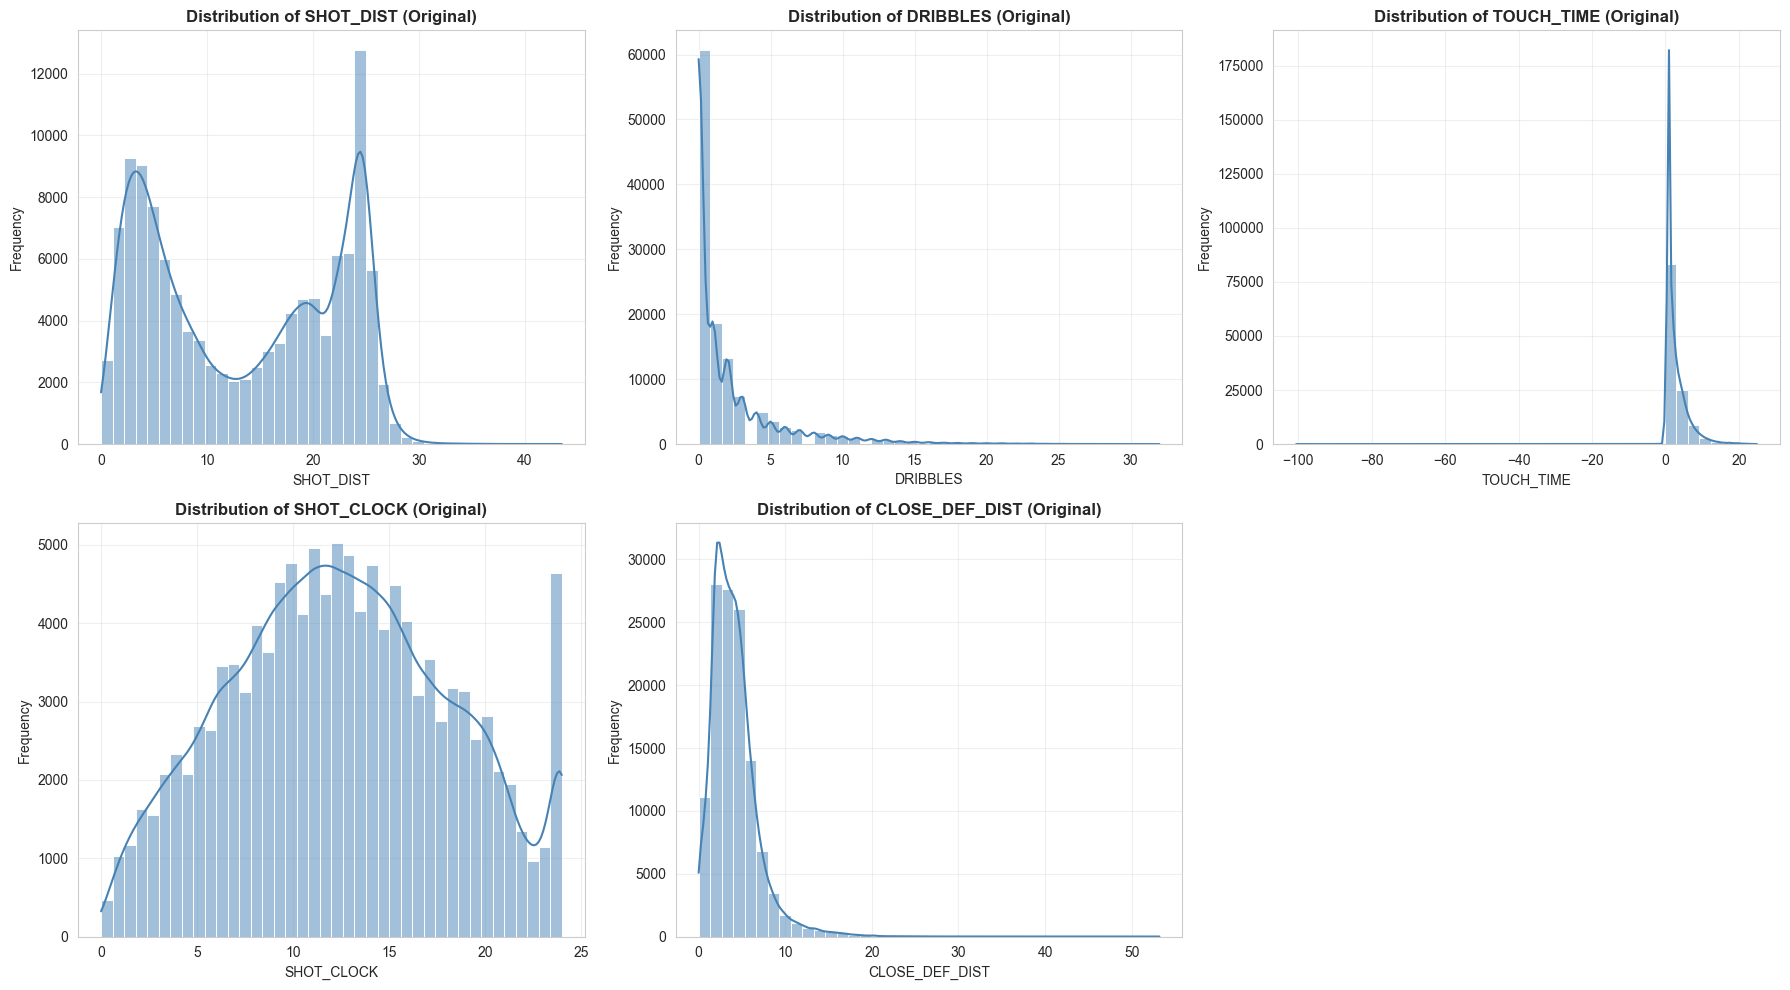

1. DISTRIBUTION ANALYSIS (ORIGINAL DATA)

SHOT_DIST:
  Mean: 13.4438, Std: 8.7771
  Skewness: 0.0530, Kurtosis: -1.5500
  Shapiro-Wilk p-value: 5.131447e-44
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness: 0.0721, Kurtosis: -0.7133
  Shapiro-Wilk p-value: 1.010595e-19
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness

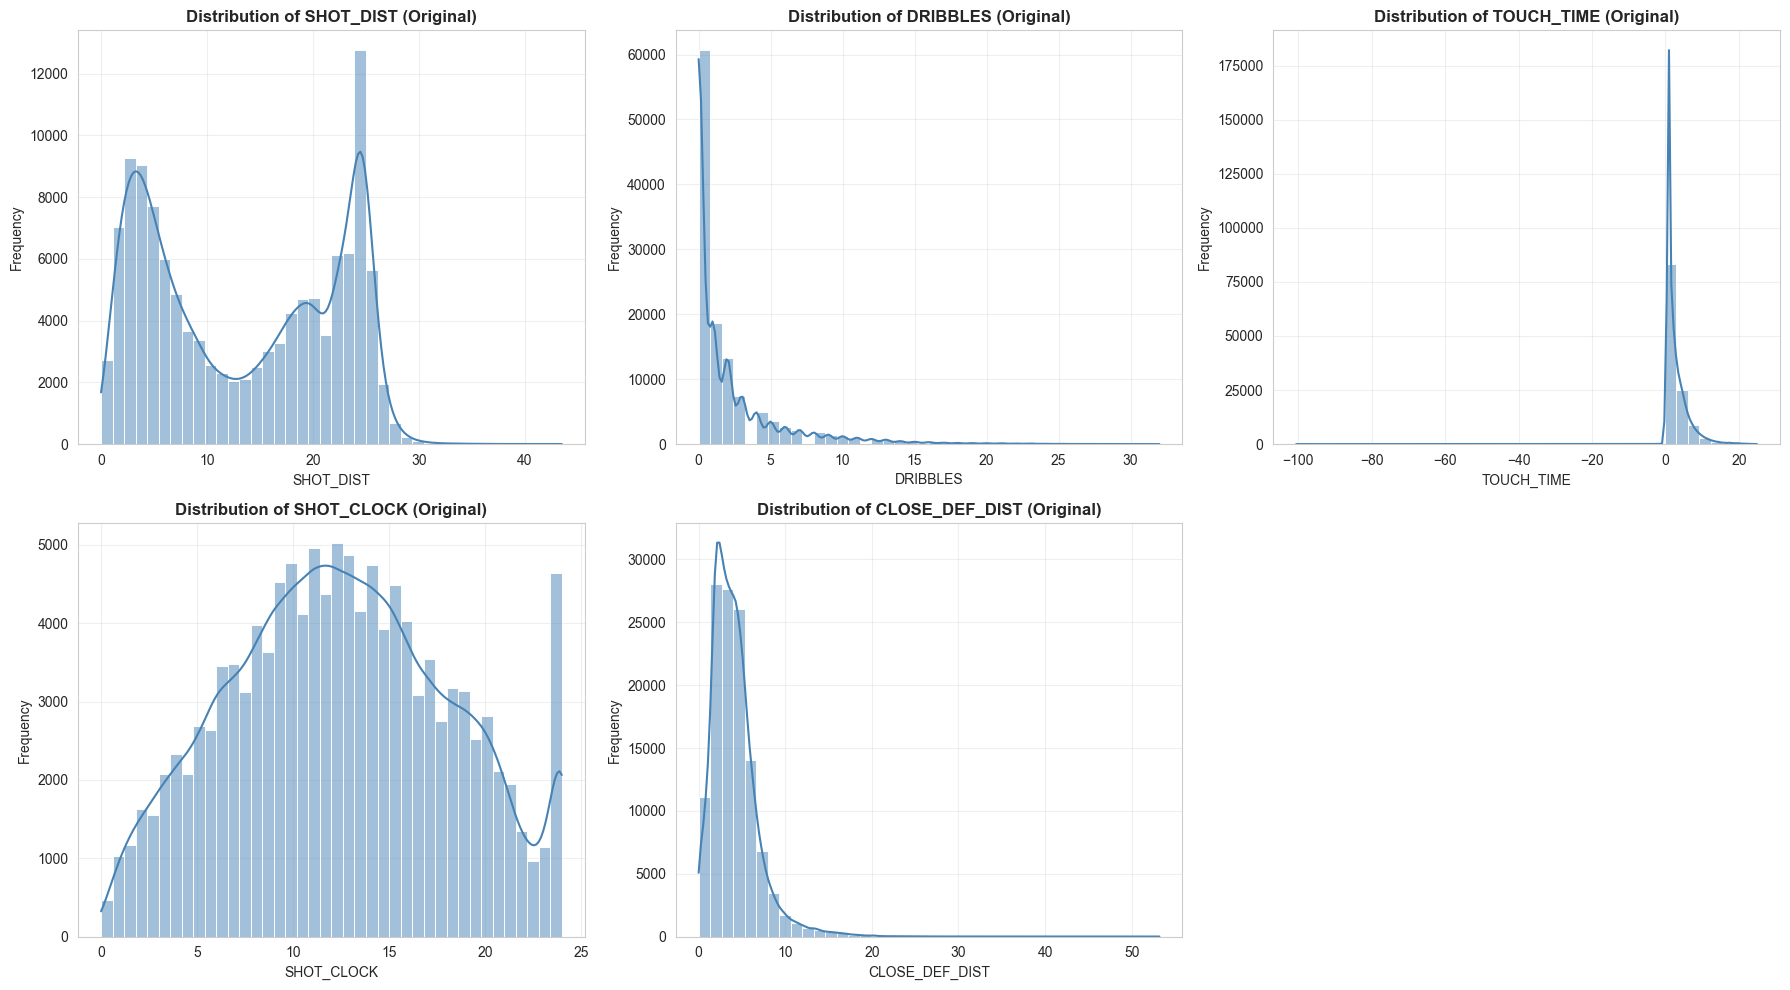


2. APPLYING BEST NORMALIZATION

SHOT_DIST:
  Original p-value: 5.131447e-44
  Transformations tested: ['Yeo-Johnson', 'Quantile', 'StandardScaler', 'RobustScaler']
    Yeo-Johnson: p-value = 4.370037e-43
    Quantile: p-value = 5.971175e-16
    StandardScaler: p-value = 5.131447e-44
    RobustScaler: p-value = 5.131447e-44
  Best Transformation: Quantile
  Best p-value: 5.971175e-16
  Status: IMPROVEMENT ✓ (-1163643588393934099085579517952.00% better)

DRIBBLES:
  Original p-value: 8.704035e-71
  Transformations tested: ['Yeo-Johnson', 'Quantile', 'StandardScaler', 'RobustScaler']
    Yeo-Johnson: p-value = 1.664662e-58
    Quantile: p-value = 1.628151e-67
    StandardScaler: p-value = 8.704035e-71
    RobustScaler: p-value = 8.704035e-71
  Best Transformation: Yeo-Johnson
  Best p-value: 1.664662e-58
  Status: IMPROVEMENT ✓ (-191251765029964.91% better)

TOUCH_TIME:
  Original p-value: 6.637508e-62
  Transformations tested: ['Yeo-Johnson', 'Quantile', 'StandardScaler', 'RobustScaler'

1. DISTRIBUTION ANALYSIS (ORIGINAL DATA)

SHOT_DIST:
  Mean: 13.4438, Std: 8.7771
  Skewness: 0.0530, Kurtosis: -1.5500
  Shapiro-Wilk p-value: 5.131447e-44
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness: 0.0721, Kurtosis: -0.7133
  Shapiro-Wilk p-value: 1.010595e-19
  Status: NON-NORMAL distribution ✗

DRIBBLES:
  Mean: 1.9892, Std: 3.4112
  Skewness: 2.7669, Kurtosis: 9.5102
  Shapiro-Wilk p-value: 8.704035e-71
  Status: NON-NORMAL distribution ✗

TOUCH_TIME:
  Mean: 2.7482, Std: 2.9572
  Skewness: 1.9506, Kurtosis: 19.3569
  Shapiro-Wilk p-value: 6.637508e-62
  Status: NON-NORMAL distribution ✗

SHOT_CLOCK:
  Mean: 12.4533, Std: 5.7633
  Skewness

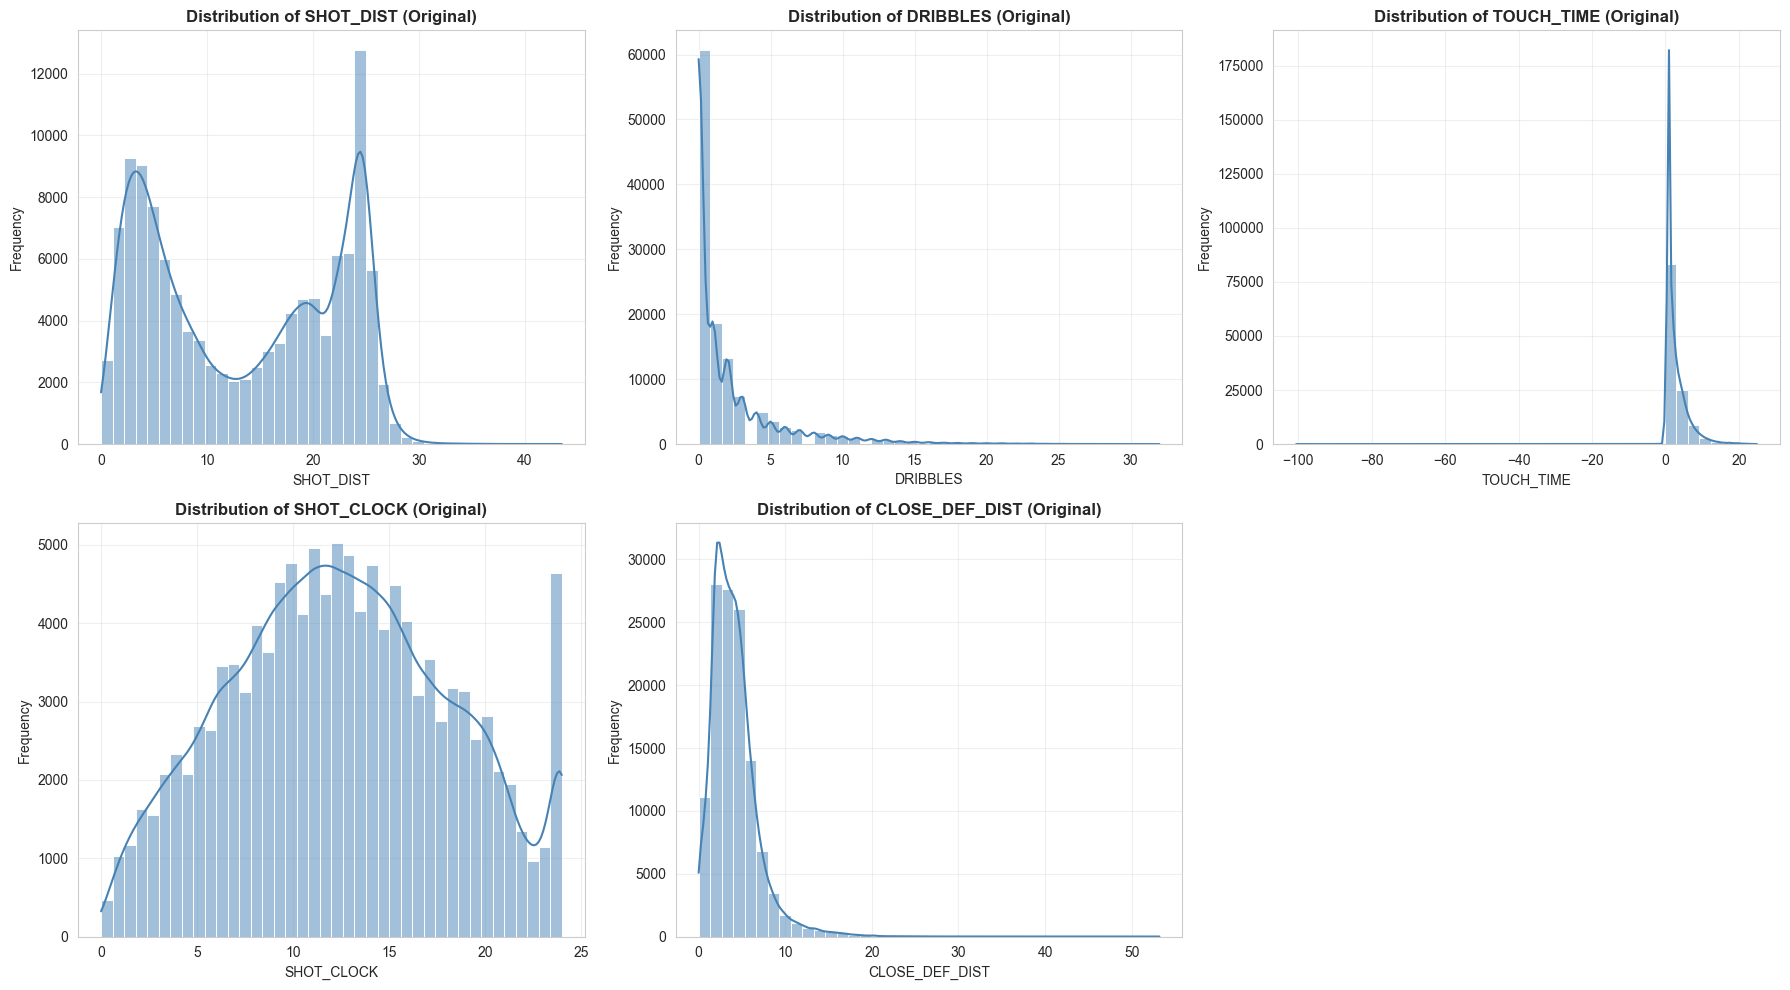


2. APPLYING BEST NORMALIZATION

SHOT_DIST:
  Original p-value: 5.131447e-44
  Transformations tested: ['Yeo-Johnson', 'Quantile', 'StandardScaler', 'RobustScaler']
    Yeo-Johnson: p-value = 4.370037e-43
    Quantile: p-value = 5.971175e-16
    StandardScaler: p-value = 5.131447e-44
    RobustScaler: p-value = 5.131447e-44
  Best Transformation: Quantile
  Best p-value: 5.971175e-16
  Status: IMPROVEMENT ✓ (-1163643588393934099085579517952.00% better)

DRIBBLES:
  Original p-value: 8.704035e-71
  Transformations tested: ['Yeo-Johnson', 'Quantile', 'StandardScaler', 'RobustScaler']
    Yeo-Johnson: p-value = 1.664662e-58
    Quantile: p-value = 1.628151e-67
    StandardScaler: p-value = 8.704035e-71
    RobustScaler: p-value = 8.704035e-71
  Best Transformation: Yeo-Johnson
  Best p-value: 1.664662e-58
  Status: IMPROVEMENT ✓ (-191251765029964.91% better)

TOUCH_TIME:
  Original p-value: 6.637508e-62
  Transformations tested: ['Yeo-Johnson', 'Quantile', 'StandardScaler', 'RobustScaler'

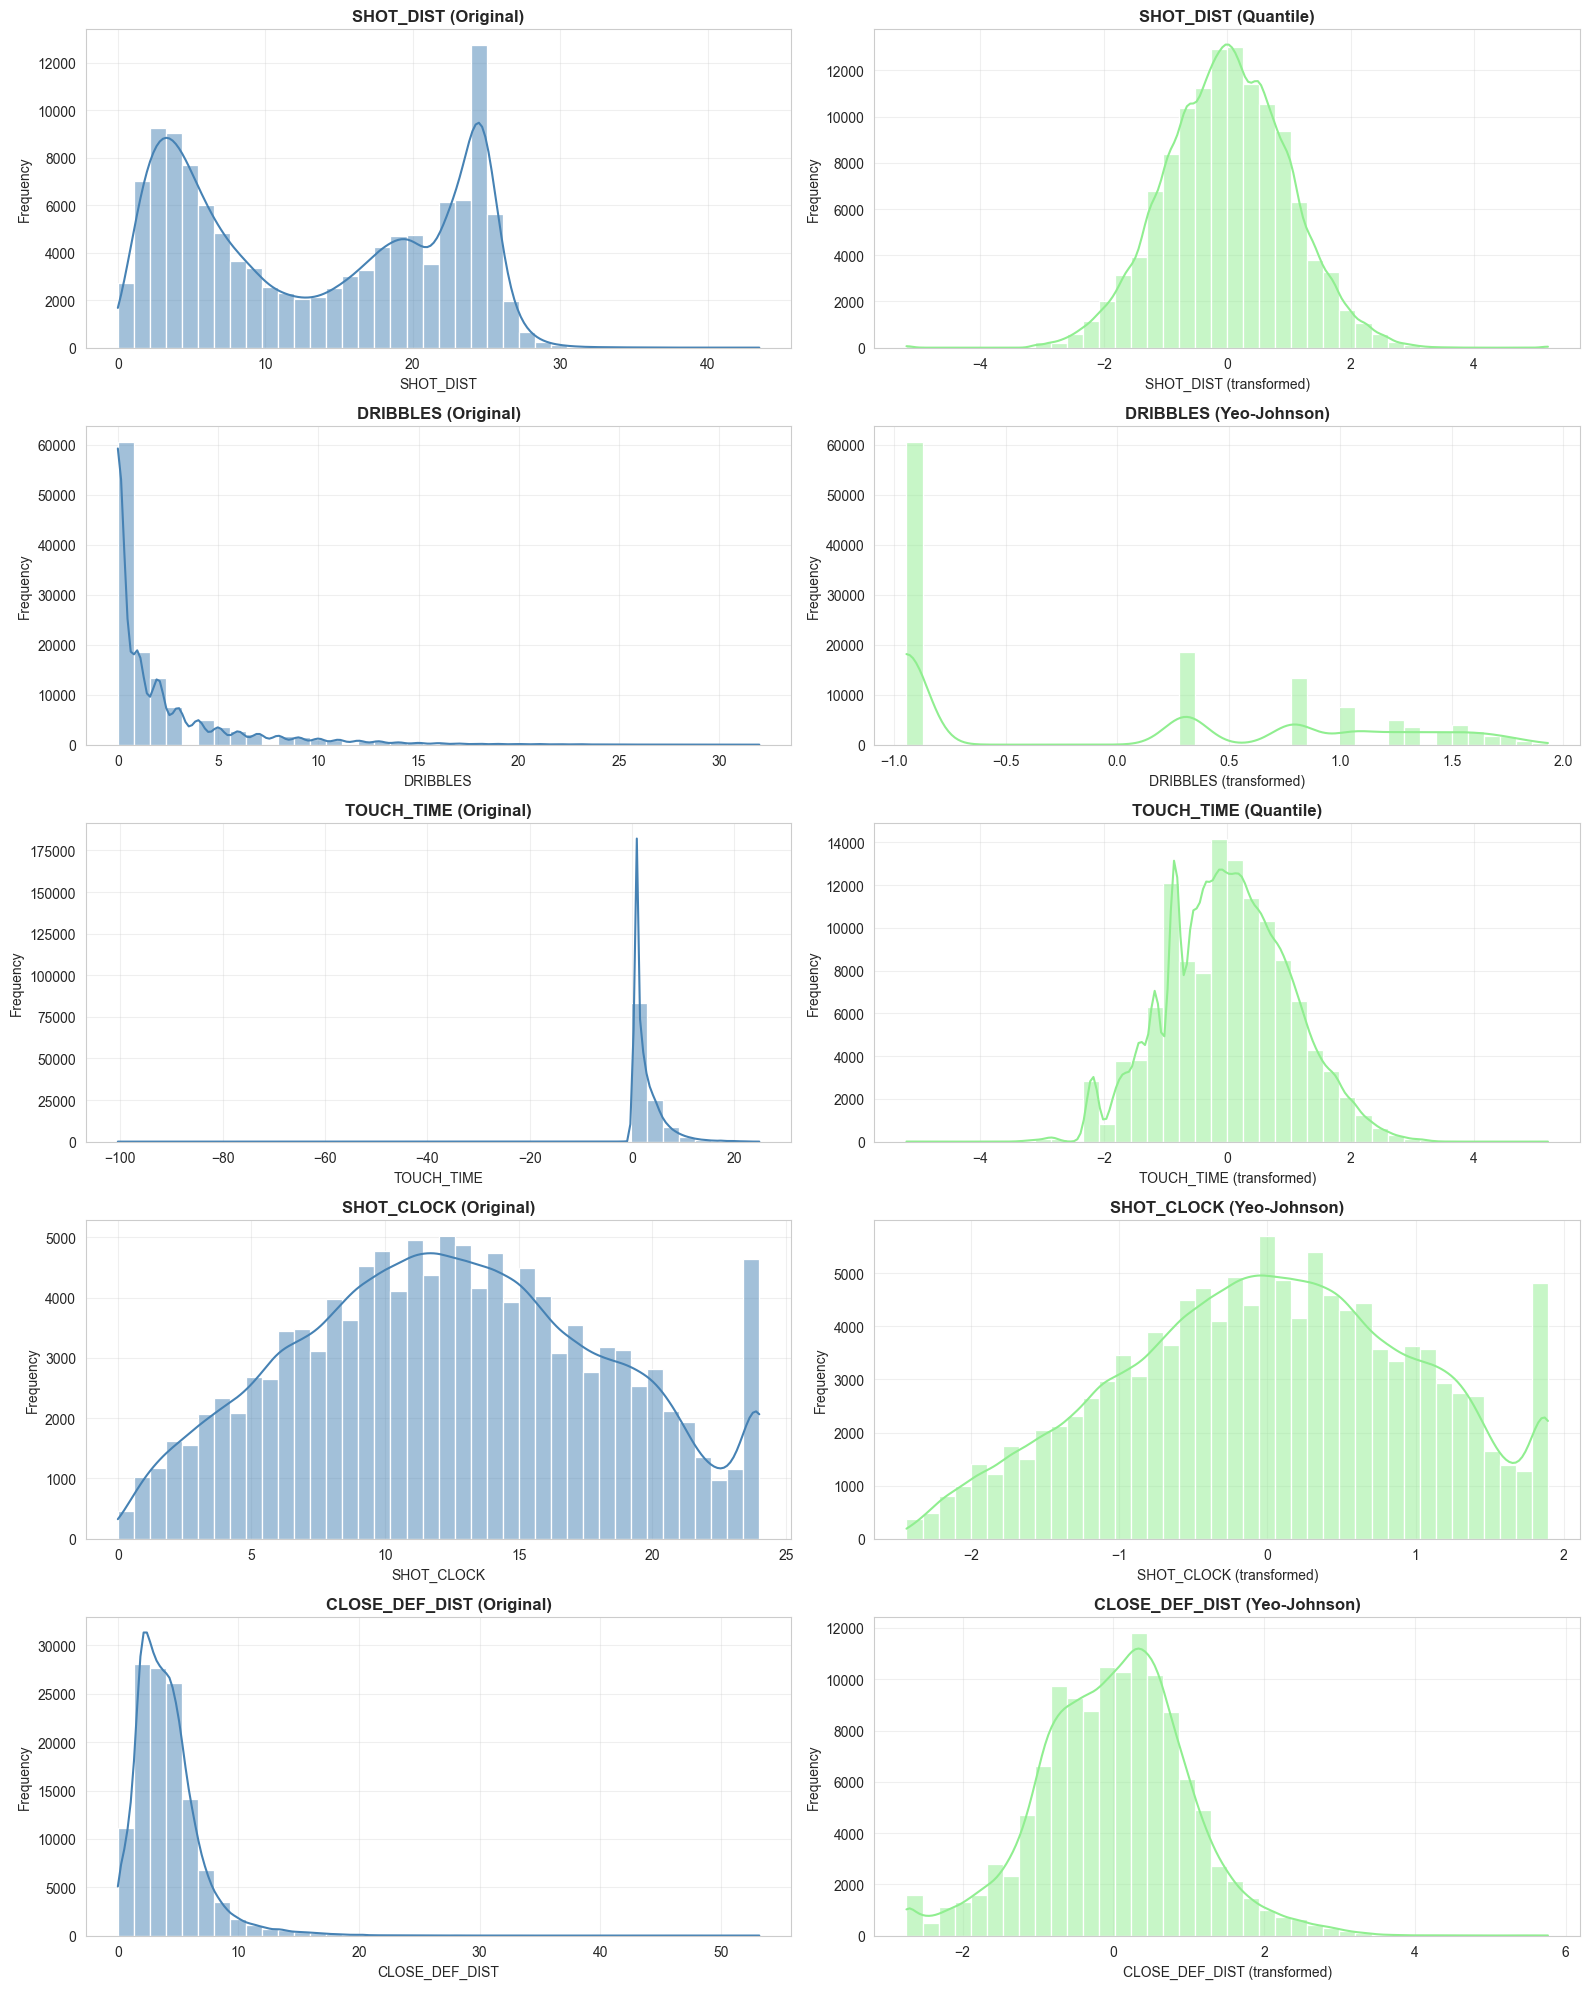


4. TRANSFORMATION SUMMARY

Best Transformations Applied:
  SHOT_DIST: Quantile
  DRIBBLES: Yeo-Johnson
  TOUCH_TIME: Quantile
  SHOT_CLOCK: Yeo-Johnson
  CLOSE_DEF_DIST: Yeo-Johnson

Transformed dataset columns:
  SHOT_DIST_transformed
  DRIBBLES_transformed
  TOUCH_TIME_transformed
  SHOT_CLOCK_transformed
  CLOSE_DEF_DIST_transformed

✓ Best Normalization Complete!


In [15]:
# ============================================================================
# 2. APPLY MULTIPLE TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("2. APPLYING MULTIPLE TRANSFORMATIONS")
print("="*70)

# Create a copy for transformed data
log_shots_transformed = log_shots.copy()
transformations = {}
best_normalizers = {}

# Test different transformers
pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
qt = QuantileTransformer(output_distribution='normal', random_state=42)

# Prepare data for transformers
X_data = log_shots[features].values

# Fit transformers that work with all data
pt_yeo_johnson.fit(X_data)
qt.fit(X_data)

# Apply transformations
yeo_johnson_transformed = pt_yeo_johnson.transform(X_data)
quantile_transformed = qt.transform(X_data)

# Box-Cox requires positive data, so prepare it separately
box_cox_transformed = None
try:
    # Add small constant to ensure all positive values
    X_data_positive = X_data + 1e-10
    # Check if all values are positive
    if (X_data_positive > 0).all():
        pt_box_cox = PowerTransformer(method='box-cox')
        pt_box_cox.fit(X_data_positive)
        box_cox_transformed = pt_box_cox.transform(X_data_positive)
except:
    print("Box-Cox transformation could not be applied due to data constraints")

for idx, feature in enumerate(features):
    print(f"\n{feature}:")
    
    best_p_value = normality_results[feature]['p_value']
    best_method = 'Original'
    best_data = log_shots[feature].values
    
    # Test Yeo-Johnson
    sample_yj = yeo_johnson_transformed[:5000, idx]
    stat_yj, p_yj = stats.shapiro(sample_yj)
    print(f"  Yeo-Johnson p-value: {p_yj:.6e}")
    if p_yj > best_p_value:
        best_p_value = p_yj
        best_method = 'Yeo-Johnson'
        best_data = yeo_johnson_transformed[:, idx]
    
    # Test Box-Cox if available
    if box_cox_transformed is not None:
        sample_bc = box_cox_transformed[:5000, idx]
        stat_bc, p_bc = stats.shapiro(sample_bc)
        print(f"  Box-Cox p-value: {p_bc:.6e}")
        if p_bc > best_p_value:
            best_p_value = p_bc
            best_method = 'Box-Cox'
            best_data = box_cox_transformed[:, idx]
    
    # Test Quantile
    sample_qt = quantile_transformed[:5000, idx]
    stat_qt, p_qt = stats.shapiro(sample_qt)
    print(f"  Quantile p-value: {p_qt:.6e}")
    if p_qt > best_p_value:
        best_p_value = p_qt
        best_method = 'Quantile'
        best_data = quantile_transformed[:, idx]
    
    transformations[feature] = best_method
    log_shots_transformed[f'{feature}_transformed'] = best_data
    
    print(f"  Best Transformation: {best_method}")
    print(f"  Original p-value: {normality_results[feature]['p_value']:.6e}")
    print(f"  Best p-value: {best_p_value:.6e}")
    
    if best_p_value > normality_results[feature]['p_value']:
        print(f"  Status: IMPROVEMENT ✓")
    else:
        print(f"  Status: No improvement")